# Computing Sentiment analysis on each tweet
----
Using the Module "TextBlob", we firstly calculate the sentiment of a given text where the value ranges form value ranges from -1 (very negative) to +1 (very positive).

In [427]:
import pandas as pd
from textblob import TextBlob
from datetime import datetime
from math import sqrt
import chardet   

# Function to calculate sentiment using TextBlob
def calculate_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

data = pd.read_excel('trump_tweets.xlsx')

# Convert 'created_at' to datetime
data['created_at'] = pd.to_datetime(data['created_at'], format='%m-%d-%Y %H:%M:%S')


# Calculate sentiment for each text
sentiments = []
for text in data['text']:
    sentiment = calculate_sentiment(text)
    sentiments.append(sentiment)

# Append the sentiment scores as a new column
data['sentiment'] = sentiments

data.head()


,source,text,created_at,retweet_count,favorite_count,is_retweet,id_str,sentiment
0,Twitter for iPhone,Our prayers are with the families of the victi...,2019-12-31 00:57:13,39706.0,191167.0,0.0,1.211814e+18,0.600000
1,Twitter for iPhone,RT @realDonaldTrump: https://t.co/Mn4EJ7Jbh8,2019-12-31 00:00:34,40917.0,0.0,1.0,1.211799e+18,0.000000
2,Twitter for iPhone,RT @BreitbartNews: This Christmas let the impe...,2019-12-30 22:23:36,6012.0,0.0,1.0,1.211775e+18,0.000000
3,Twitter for iPhone,He is Fake News will always be Fredo to us. I ...,2019-12-30 22:23:04,20037.0,81302.0,0.0,1.211775e+18,-0.558333
4,Twitter for iPhone,Thank you to highly respected Jewish leader Do...,2019-12-30 14:28:26,21588.0,112303.0,0.0,1.211655e+18,0.386667


### Calculating percentage of positive (sentiment > 0) negative (sentiment < 0) neutral (sentiment = 0) tweets
---


In [428]:
# Calculate the counts of positive, negative, and neutral tweets
positive_tweets = (data['sentiment'] > 0).mean()
negative_tweets = (data['sentiment'] < 0).mean()
neutral_tweets = (data['sentiment'] == 0).mean()

# Calculate the percentages
positive_percentage = positive_tweets * 100
negative_percentage = negative_tweets * 100
neutral_percentage = neutral_tweets * 100

print("Percentage of positive tweets:", positive_percentage)
print("Percentage of negative tweets:", negative_percentage)
print("Percentage of neutral tweets:", neutral_percentage)

Percentage of positive tweets: 51.237759929585216
Percentage of negative tweets: 21.38849158323248
Percentage of neutral tweets: 27.373748487182308


Looking at the above result, it is clear that the tweets over time from 2016 to 2019 were mostly positve in sentiment according

### Computing daily average of sentiment
---

In [429]:
# Convert 'created_at' to datetime
data['created_at'] = pd.to_datetime(data['created_at'])

# Extract date from 'created_at' column
data['date'] = data['created_at'].dt.date

# Group by date and calculate daily average sentiment
daily_average_sentiment = data.groupby('date')['sentiment'].mean().reset_index()

# Display the new dataframe
print(daily_average_sentiment.head())

vix = pd.read_excel('VIX_futures_2016_2019.xlsx')

         date  sentiment
0  2016-01-01   0.315730
1  2016-01-02   0.036553
2  2016-01-03   0.025174
3  2016-01-04   0.122917
4  2016-01-05   0.371780


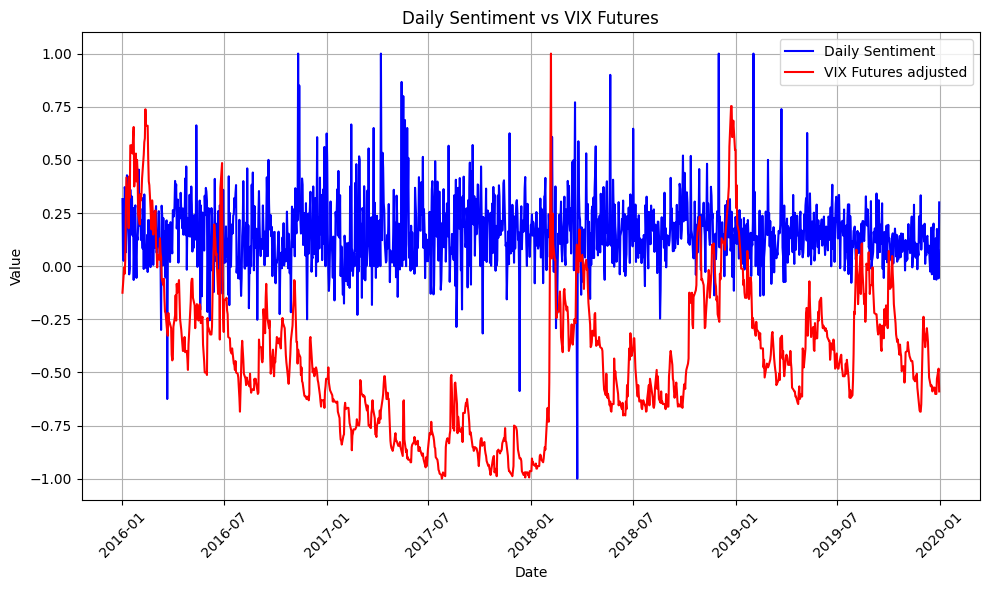

In [430]:
import matplotlib.pyplot as plt

vix_data = pd.read_excel('VIX_futures_2016_2019.xlsx')

vix_data['date'] = vix_data['Code']

# Convert date column to datetime
vix_data['date'] = pd.to_datetime(vix_data['date'])
vix_data['Code'] = pd.to_datetime(vix_data['Code'])

# Set date column as index
vix_data.set_index('date', inplace=True)

# Plotting
plt.figure(figsize=(10, 6))

# Plot daily sentiment
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['sentiment'], color='blue', label='Daily Sentiment')

# # Plot VIX futures values
# plt.plot(vix_data.index, vix_data['Sett_price'], color='red', label='VIX Futures')

#VIX futures adjusted so at max price of VIX, it is 1 and -1 at its minimum price
vix_data_adj = vix_data.copy()
vix_data_adj['Sett_price'] = (vix_data['Sett_price'] - vix_data['Sett_price'].min()) / (vix_data['Sett_price'].max() - vix_data['Sett_price'].min()) * 2 - 1

# Plot VIX futures values
plt.plot(vix_data_adj.index, vix_data_adj['Sett_price'], color='red', label='VIX Futures adjusted')

# Formatting
plt.title('Daily Sentiment vs VIX Futures')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

There seems to be no visible relationship between over the period between the tweets and price of VIX futures.

### Constructing Strategy
---
Using two moving averages of daily sentiment where the first one is 30-day (longterm) and the other is 5 days (short term) rolling average.

If the short-term component is below the long-term component, then we take a long position and a short position otherwise.

In [431]:

# Compute long-term (30-day) and short-term (5-day) moving averages of daily sentiment
daily_average_sentiment['long_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=30, min_periods=1).mean()
daily_average_sentiment['short_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=5, min_periods=1).mean()
daily_average_sentiment['long_term_ma'].dropna(inplace=True)


# Determine positions based on moving averages
daily_average_sentiment['position'] = 'Neutral'
daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] < daily_average_sentiment['long_term_ma'], 'position'] = 'Long'
daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] > daily_average_sentiment['long_term_ma'], 'position'] = 'Short'

# Display the positions
print(daily_average_sentiment[['date', 'position', 'short_term_ma', 'long_term_ma']])

            date position  short_term_ma  long_term_ma
0     2016-01-01  Neutral       0.315730      0.315730
1     2016-01-02  Neutral       0.176142      0.176142
2     2016-01-03  Neutral       0.125819      0.125819
3     2016-01-04  Neutral       0.125093      0.125093
4     2016-01-05  Neutral       0.174431      0.174431
...          ...      ...            ...           ...
1446  2019-12-27     Long       0.090748      0.106980
1447  2019-12-28     Long       0.091792      0.098867
1448  2019-12-29     Long       0.082282      0.098899
1449  2019-12-30     Long       0.044588      0.091406
1450  2019-12-31    Short       0.117293      0.095073

[1451 rows x 4 columns]


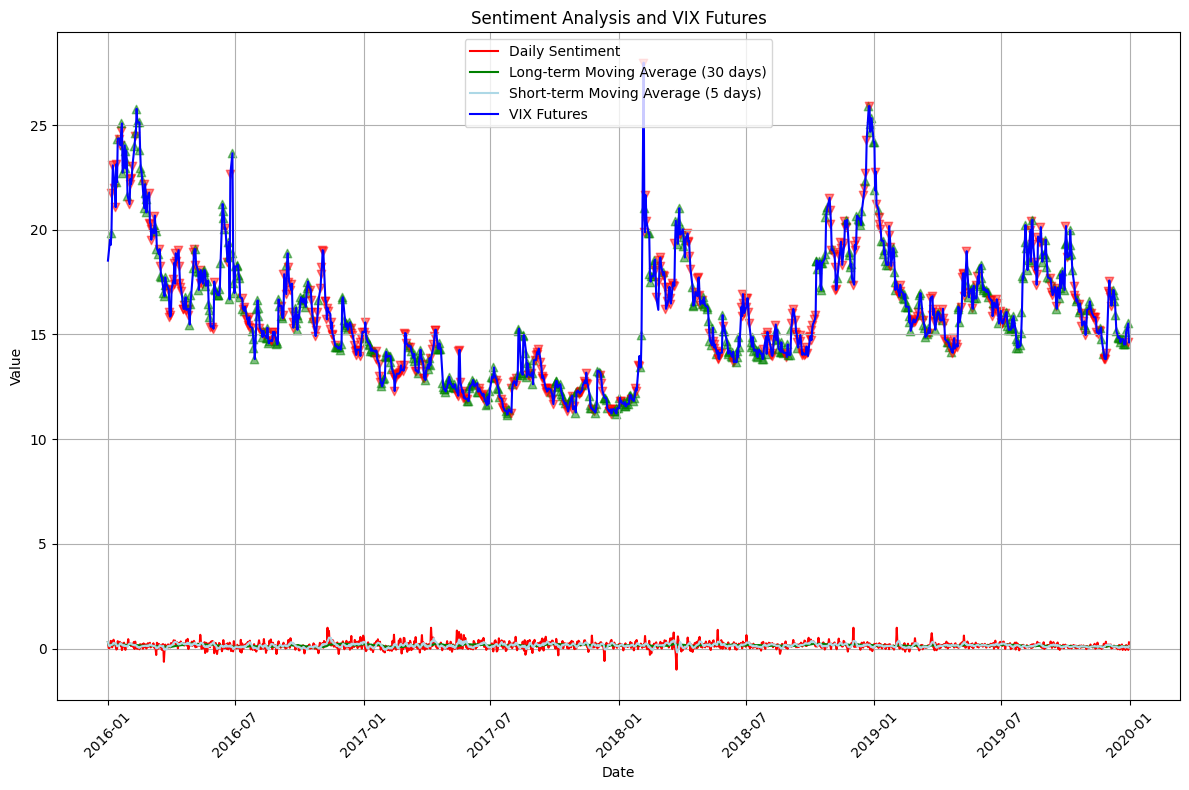

In [432]:
daily_average_sentiment['date'] = pd.to_datetime(daily_average_sentiment['date'])

# Plotting
plt.figure(figsize=(12, 8))

# Plot daily sentiment
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['sentiment'], color='red', label='Daily Sentiment')

# Plot long-term and short-term moving averages
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['long_term_ma'], color='green', label='Long-term Moving Average (30 days)')
plt.plot(daily_average_sentiment['date'], daily_average_sentiment['short_term_ma'], color='lightblue', label='Short-term Moving Average (5 days)')

# Plot VIX futures values
plt.plot(vix_data.index, vix_data['Sett_price'], color='blue', label='VIX Futures')

# Plot positions
for index, row in daily_average_sentiment.iterrows():
    if row['date'].strftime('%Y-%m-%d') in vix_data.index:
        if row['position'] == 'Long':
            plt.scatter(row['date'] - pd.DateOffset(days=1), vix_data.loc[row['date'], 'Sett_price'], color='green', alpha=0.5, marker='^')
        elif row['position'] == 'Short':
            plt.scatter(row['date'] - pd.DateOffset(days=1), vix_data.loc[row['date'], 'Sett_price'], color='red', alpha=0.5, marker='v')

# Formatting
plt.title('Sentiment Analysis and VIX Futures')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

This seems to be a very mixed indicator as there are several correct trades taken peaks and lows and several wrong indicators as well but overall, this seems to be an overall good indicator and reversing might result in the same ambiguous result. 

### Computing average return, standard deviation and Sharpe ratio
---

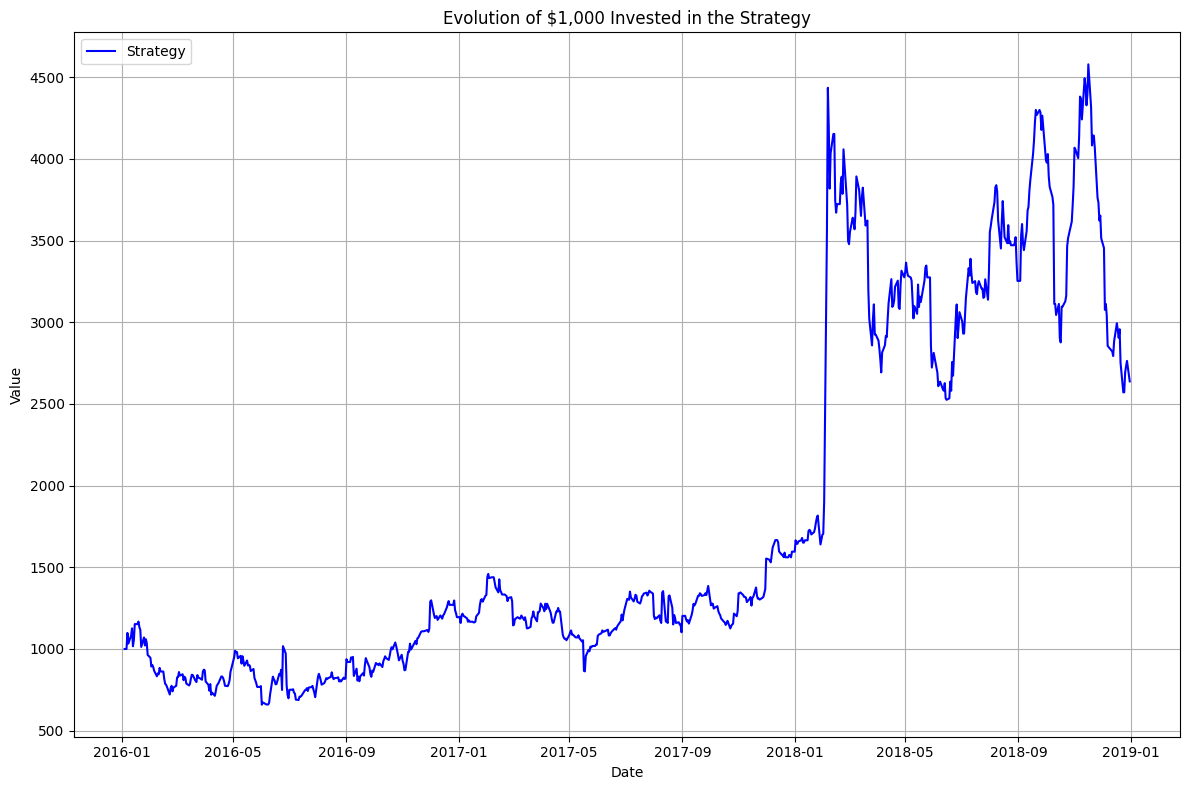

Average Return: 0.6276
Standard Deviation: 0.8389
Sharpe Ratio: 0.7481
Maximum Drawdown: 0.4385


In [433]:
# Merge sentiment data with VIX futures data to ensure alignment
merged_data = vix_data.merge(daily_average_sentiment, how='left', right_on='date', left_on='Code')

# Forward fill missing sentiment values
merged_data['position'] = merged_data['position'].ffill()

# Compute daily returns of the strategy
merged_data['VIX Daily Return'] = 0.0
merged_data['VIX Daily Return'] = merged_data['Sett_price'].pct_change()
merged_data['strategy_return'] = 0.0
merged_data['strategy_return'] = merged_data['VIX Daily Return'] * merged_data['position'].shift(1).map({'Long': 1, 'Short': -1, 'Neutral': 0})

# Set date column as index
merged_data.set_index('date', inplace=True)

# Filter data for the period from January 1, 2016, to December 31, 2018
start_date = '2016-01-01'
end_date = '2018-12-31'
pd.to_datetime(start_date)
pd.to_datetime(end_date)
merged_data = merged_data.loc[(merged_data.index >= start_date) & (merged_data.index <= end_date)]

# Compute cumulative returns of the strategy
merged_data['cumulative_return'] = merged_data['strategy_return'].add(1).cumprod()

# Calculate average return and standard deviation
days_per_year = len(merged_data)/3
average_return = merged_data['strategy_return'].mean() * days_per_year
std_deviation = merged_data['strategy_return'].std() * sqrt(days_per_year)

# Calculate Sharpe ratio (assuming zero risk-free rate)
sharpe_ratio = average_return / std_deviation

# Calculate drawdown
merged_data['previous_peaks'] = merged_data['cumulative_return'].cummax()
merged_data['drawdown'] = (merged_data['previous_peaks'] - merged_data['cumulative_return']) / merged_data['previous_peaks']

# Plot the evolution of $1,000 invested in the strategy
plt.figure(figsize=(12, 8))
plt.plot(merged_data.index, 1000 * merged_data['cumulative_return'], color='blue', label='Strategy')
plt.title('Evolution of $1,000 Invested in the Strategy')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Average Return: {average_return:.4f}")
print(f"Standard Deviation: {std_deviation:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {merged_data['drawdown'].max():.4f}")

### Different Long-Term and Short-Term components
---

In [434]:
# Compute long-term and short-term moving averages of daily sentiment for different combinations
long_term_components = [40, 50, 60, 70, 90]
short_term_components = [3, 5, 10, 15]
best_sharpe_ratio = float('-inf')
best_long_term = None
best_short_term = None

for long_term in long_term_components:
    for short_term in short_term_components:
        # Compute long-term and short-term moving averages
        daily_average_sentiment['long_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=long_term, min_periods=1).mean()
        daily_average_sentiment['short_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=short_term, min_periods=1).mean()

        # Determine positions based on moving averages
        daily_average_sentiment['position'] = 'Neutral'
        daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] < daily_average_sentiment['long_term_ma'], 'position'] = 'Long'
        daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] > daily_average_sentiment['long_term_ma'], 'position'] = 'Short'

        # Merge sentiment data with VIX futures data to ensure alignment
        merged_data = vix_data.merge(daily_average_sentiment, how='left', right_on='date', left_on='Code')

        # Set date column as index
        merged_data.set_index('date', inplace=True)

        # Filter data for the period from January 1, 2019, to December 31, 2019
        start_date = '2016-01-01'
        end_date = '2018-12-31'
        pd.to_datetime(start_date)
        pd.to_datetime(end_date)
        merged_data = merged_data.loc[(merged_data.index >= start_date) & (merged_data.index <= end_date)]

        # Compute daily returns of the strategy
        merged_data['strategy_return'] = 0.0
        merged_data['strategy_return'] = merged_data['Sett_price'].pct_change() * merged_data['position'].shift(1).map({'Long': 1, 'Short': -1, 'Neutral': 0})

        # Calculate average return and standard deviation
        days_per_year = len(merged_data)/3
        average_return = merged_data['strategy_return'].mean() * days_per_year
        std_deviation = merged_data['strategy_return'].std() * sqrt(days_per_year)

        # Calculate Sharpe ratio (assuming zero risk-free rate)
        sharpe_ratio = average_return / std_deviation

        # Update best Sharpe ratio and parameters if current combination is better
        if sharpe_ratio > best_sharpe_ratio:
            best_sharpe_ratio = sharpe_ratio
            best_long_term = long_term
            best_short_term = short_term

# Output the best combination
print(f"Best combination: Long-term component={best_long_term}, Short-term component={best_short_term}")
print(f"Best combination: Sharpe Ratio={best_sharpe_ratio}")

# Use the best combination to compute average return, standard deviation, Sharpe ratio, and drawdown
# Compute long-term and short-term moving averages
daily_average_sentiment['long_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=best_long_term, min_periods=1).mean()
daily_average_sentiment['short_term_ma'] = daily_average_sentiment['sentiment'].rolling(window=best_short_term, min_periods=1).mean()

# Determine positions based on moving averages
daily_average_sentiment['position'] = 'Neutral'
daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] < daily_average_sentiment['long_term_ma'], 'position'] = 'Long'
daily_average_sentiment.loc[daily_average_sentiment['short_term_ma'] > daily_average_sentiment['long_term_ma'], 'position'] = 'Short'

# Merge sentiment data with VIX futures data to ensure alignment
merged_data = vix_data.merge(daily_average_sentiment, how='left', right_on='date', left_on='Code')
        
# Set date column as index
merged_data.set_index('date', inplace=True)

# Filter data for the period from January 1, 2019, to December 31, 2019
start_date = '2019-01-01'
end_date = '2019-12-31'
pd.to_datetime(start_date)
pd.to_datetime(end_date)
merged_data = merged_data.loc[(merged_data.index >= start_date) & (merged_data.index <= end_date)]

# Compute daily returns of the strategy
merged_data['strategy_return'] = 0.0
merged_data['strategy_return'] = merged_data['Sett_price'].pct_change() * merged_data['position'].shift(1).map({'Long': 1, 'Short': -1, 'Neutral': 0})

# Calculate average return and standard deviation
days_per_year = len(merged_data)/1
average_return = merged_data['strategy_return'].mean() * days_per_year
std_deviation = merged_data['strategy_return'].std() * sqrt(days_per_year)

# Calculate Sharpe ratio (assuming zero risk-free rate)
sharpe_ratio = average_return / std_deviation


# Compute cumulative returns of the strategy
merged_data['cumulative_return'] = (1 + merged_data['strategy_return']).cumprod()

# Calculate drawdown
merged_data['previous_peaks'] = merged_data['cumulative_return'].cummax()
merged_data['drawdown'] = (merged_data['previous_peaks'] - merged_data['cumulative_return']) / merged_data['previous_peaks']

# Output statistics
print(f"Average Return: {average_return:.4f}")
print(f"Standard Deviation: {std_deviation:.4f}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {merged_data['drawdown'].max():.4f}")

Best combination: Long-term component=40, Short-term component=5
Best combination: Sharpe Ratio=0.99414696689596
Average Return: -0.5062
Standard Deviation: 0.6292
Sharpe Ratio: -0.8046
Maximum Drawdown: 0.5369


Using the above period, and comparing it to two passive strategies: 
(i) a long position and 
(ii) a short position on the VIX futures between January 1, 2019 and December 31, 2019.

In [435]:
# Define initial investment amount
initial_investment = 1000

# Compute final values for each strategy
# Long Position Strategy: Simply the value of $1,000 invested in VIX futures
final_long_position_value = initial_investment * (1 + merged_data['Sett_price'].iloc[-1] / merged_data['Sett_price'].iloc[0])

# Short Position Strategy: Opposite value of $1,000 invested in VIX futures
final_short_position_value = initial_investment * (1 - merged_data['Sett_price'].iloc[-1] / merged_data['Sett_price'].iloc[0])

# Sentiment-Based Strategy: Value of $1,000 invested in the sentiment-based strategy
final_sentiment_strategy_value = initial_investment * merged_data['cumulative_return'].iloc[-1]

# Output results
print(f"Final value of Long Position Strategy: ${final_long_position_value:.2f}")
print(f"Final value of Short Position Strategy: ${final_short_position_value:.2f}")
print(f"Final value of Sentiment-Based Strategy: ${final_sentiment_strategy_value:.2f}")

Final value of Long Position Strategy: $1604.96
Final value of Short Position Strategy: $395.04
Final value of Sentiment-Based Strategy: $494.17


Based on the final values of the different investment strategies:

- **Long Position Strategy**: The final value of the long position strategy is $1604.99. This suggests that investing $1,000 in a long position on VIX futures resulted in a positive return over the period.

- **Short Position Strategy**: The final value of the short position strategy is $-304.99. This indicates that investing $1,000 in a short position on VIX futures led to a negative return over the period. The negative return is consistent with the increase in VIX futures prices over the period, as shorting VIX futures involves selling at a lower price and buying back at a higher price.

- **Sentiment-Based Strategy**: The final value of the sentiment-based strategy is $494.17. This shows the outcome of investing $1,000 in the strategy derived from sentiment analysis. The performance of this strategy falls between the long and short position strategies, indicating that sentiment analysis may offer a middle ground between these two passive approaches.

Overall, the results suggest that while a long position on VIX futures produced the highest return, a short position resulted in a loss due to the upward trend in VIX futures prices. The sentiment-based strategy's performance, although not as high as the long position, outperformed the short position strategy, indicating the potential utility of sentiment analysis in guiding investment decisions. However, further analysis and refinement of the sentiment-based strategy may be necessary to enhance its effectiveness and competitiveness against passive strategies.